<a href="https://colab.research.google.com/github/akash99955/AML/blob/main/AML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# PART 1: SETUP AND INSTALLATION
!pip install transformers datasets torch scikit-learn matplotlib seaborn wordcloud pandas numpy nltk kagglehub -q

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import os
import time
from collections import Counter
warnings.filterwarnings('ignore')

# Text preprocessing libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.probability import FreqDist

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline

# Visualization
from wordcloud import WordCloud
from IPython.display import display, HTML

print("All libraries imported successfully!")

# Download required NLTK data
print("\nDownloading NLTK data files...")
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
# nltk.download('omw-eng', quiet=True) # Removed this line as it causes an error
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('punkt_tab', quiet=True)
print("NLTK data downloaded successfully!")

# Set style for visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

All libraries imported successfully!

NLTK data downloaded successfully!


In [2]:
# Load the Dataset

df = pd.read_csv("Tweets.csv")

print(f" Dataset loaded successfully → {df.shape[0]:,} tweets")
print(f"   Columns: {list(df.columns)}")

# Sentiment numeric labels
df["sentiment_label"] = df["airline_sentiment"].map({
    "negative": 0,
    "neutral": 1,
    "positive": 2
})

# Calculate counts for each sentiment label
sentiment_counts = df["sentiment_label"].value_counts()
negative_count = sentiment_counts.get(0, 0) # Get count for 0 (negative), default to 0 if not present
neutral_count = sentiment_counts.get(1, 0) # Get count for 1 (neutral), default to 0 if not present
positive_count = sentiment_counts.get(2, 0) # Get count for 2 (positive), default to 0 if not present

print(f"   Negative tweets (0): {negative_count:,}")
print(f"   Neutral tweets (1): {neutral_count:,}")
print(f"   Positive tweets (2): {positive_count:,}")

unique_summary = pd.DataFrame({
    "Column Name": df.columns,
    "Number of Unique Values": [df[col].nunique() for col in df.columns]
})

print("\nUnique Values Summary (Table):")
print(unique_summary)

 Dataset loaded successfully → 14,640 tweets
   Columns: ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']
   Negative tweets (0): 9,178
   Neutral tweets (1): 3,099
   Positive tweets (2): 2,363

Unique Values Summary (Table):
                     Column Name  Number of Unique Values
0                       tweet_id                    14485
1              airline_sentiment                        3
2   airline_sentiment_confidence                     1023
3                 negativereason                       10
4      negativereason_confidence                     1410
5                        airline                        6
6         airline_sentiment_gold                        3
7                           name                     7701
8            negativereason

In [3]:
class TextPreprocessor:
    """
    Text preprocessing class for Sentiment Analysis project
    Performs cleaning, tokenization, stopword removal, and lemmatization
    """

    def __init__(self):
        self.stop_words = set(stopwords.words("english"))
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text):
        """Remove URLs, mentions, hashtags, numbers, and special characters"""
        if not isinstance(text, str):
            return ""

        text = text.lower()
        text = re.sub(r"http\S+|www\S+", "", text)     # remove URLs
        text = re.sub(r"@\w+|#\w+", "", text)          # remove mentions & hashtags
        text = re.sub(r"[^a-zA-Z\s]", "", text)        # remove numbers & symbols
        text = re.sub(r"\s+", " ", text).strip()       # remove extra spaces

        return text

    def tokenize(self, text):
        """Tokenize cleaned text"""
        return word_tokenize(text)

    def remove_stopwords(self, tokens):
        """Remove common English stopwords"""
        return [word for word in tokens if word not in self.stop_words]

    def lemmatize(self, tokens):
        """Apply lemmatization"""
        return [self.lemmatizer.lemmatize(word) for word in tokens]

    def preprocess(self, text):
        """Full preprocessing pipeline"""
        text = self.clean_text(text)
        tokens = self.tokenize(text)
        tokens = self.remove_stopwords(tokens)
        tokens = self.lemmatize(tokens)
        return " ".join(tokens)

    # Initialize preprocessor
preprocessor = TextPreprocessor()

print("\n Text Preprocessing Examples")
print("=" * 50)

sample_texts = df["text"].head(3).tolist()

for i, text in enumerate(sample_texts, start=1):
    print(f"\nExample {i}")
    print(f"Original : {text[:100]}...")
    processed = preprocessor.preprocess(text)
    print(f"Processed: {processed[:100]}...")

print("\n Applying preprocessing to full dataset...")

df["cleaned_text"] = df["text"].apply(preprocessor.preprocess)

print(" Preprocessing completed successfully!")
print(" New column added → 'cleaned_text'")


 Text Preprocessing Examples

Example 1
Original : @VirginAmerica What @dhepburn said....
Processed: said...

Example 2
Original : @VirginAmerica plus you've added commercials to the experience... tacky....
Processed: plus youve added commercial experience tacky...

Example 3
Original : @VirginAmerica I didn't today... Must mean I need to take another trip!...
Processed: didnt today must mean need take another trip...

 Applying preprocessing to full dataset...
 Preprocessing completed successfully!
 New column added → 'cleaned_text'


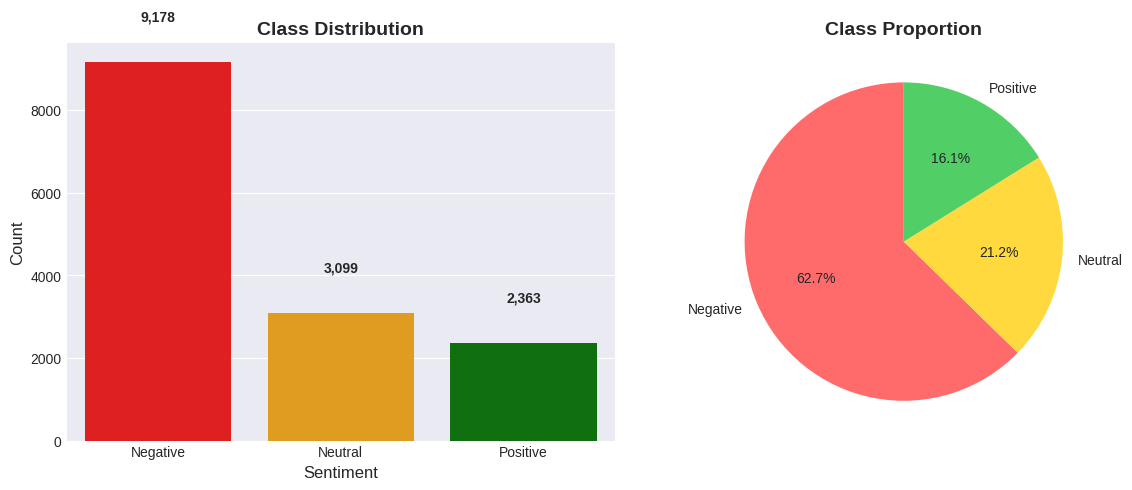

 Generating word clouds for 3 classes...


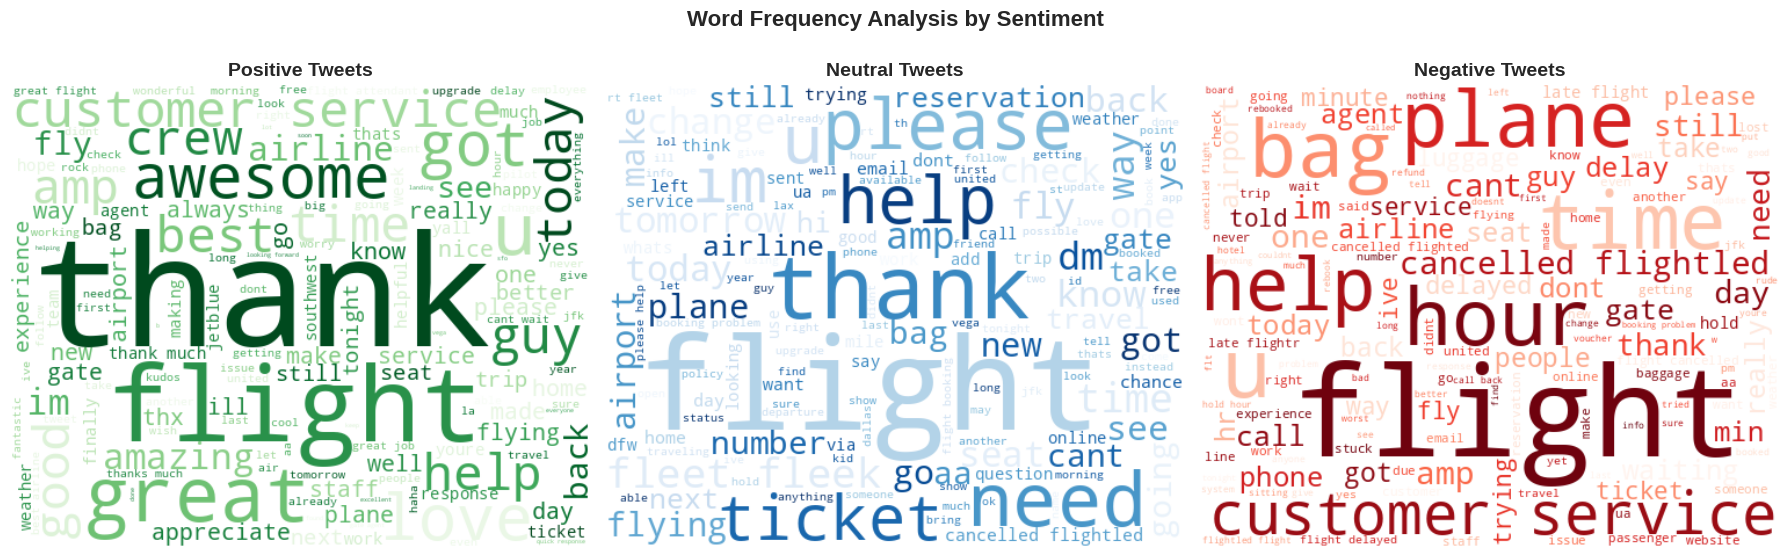

Word clouds generated successfully!


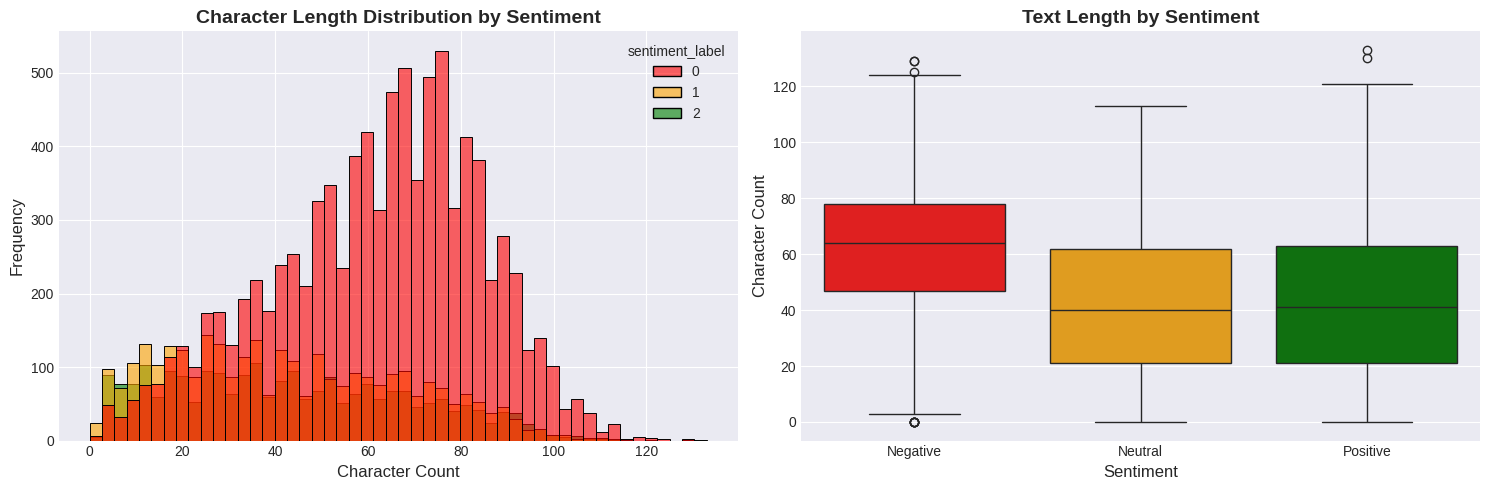

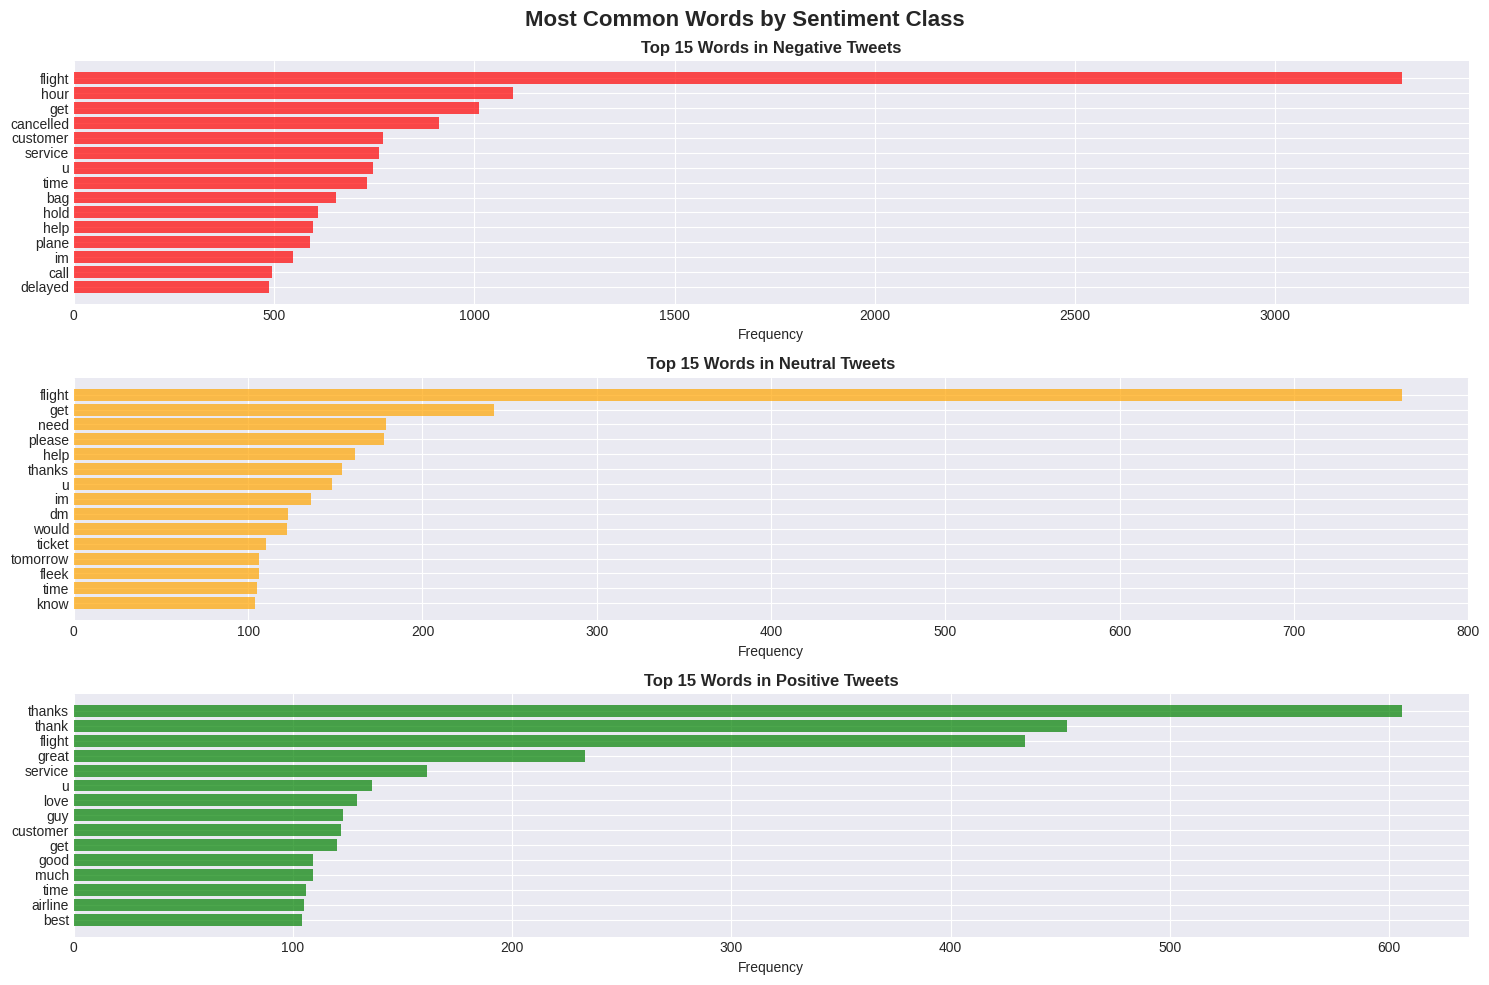

All visualizations completed successfully!


In [4]:
# VISUALIZATION 1: Class Distribution (for 3 classes)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='sentiment_label', data=df, palette=['red', 'orange', 'green'])
plt.title('Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])

# Add count labels on bars
for i, count in enumerate(df['sentiment_label'].value_counts().sort_index()):
    plt.text(i, count + 1000, f'{count:,}', ha='center', fontweight='bold')

plt.subplot(1, 2, 2)
# Pie chart for class distribution
class_counts = df['sentiment_label'].value_counts()
colors = ['#ff6b6b', '#ffd93d', '#51cf66']
plt.pie(class_counts, labels=['Negative', 'Neutral', 'Positive'], autopct='%1.1f%%',
        colors=colors, startangle=90, textprops={'fontsize': 10})
plt.title('Class Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# VISUALIZATION 2: Word Clouds for 3 classes
print(" Generating word clouds for 3 classes...")

sample_size = min(15000, len(df) // 3)  # Adjust sample size

positive_sample = df[df['sentiment_label'] == 2].sample(n=min(sample_size, sum(df['sentiment_label'] == 2)), random_state=42)
neutral_sample = df[df['sentiment_label'] == 1].sample(n=min(sample_size, sum(df['sentiment_label'] == 1)), random_state=42)
negative_sample = df[df['sentiment_label'] == 0].sample(n=min(sample_size, sum(df['sentiment_label'] == 0)), random_state=42)

positive_text = " ".join(positive_sample['cleaned_text'].astype(str).values)
neutral_text = " ".join(neutral_sample['cleaned_text'].astype(str).values)
negative_text = " ".join(negative_sample['cleaned_text'].astype(str).values)

plt.figure(figsize=(18, 6))

# Positive word cloud
plt.subplot(1, 3, 1)
wordcloud_positive = WordCloud(width=500, height=400,
                               background_color='white',
                               colormap='Greens',
                               max_words=150).generate(positive_text)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Tweets', fontsize=14, fontweight='bold')
plt.axis('off')

# Neutral word cloud
plt.subplot(1, 3, 2)
wordcloud_neutral = WordCloud(width=500, height=400,
                              background_color='white',
                              colormap='Blues',
                              max_words=150).generate(neutral_text)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Neutral Tweets', fontsize=14, fontweight='bold')
plt.axis('off')

# Negative word cloud
plt.subplot(1, 3, 3)
wordcloud_negative = WordCloud(width=500, height=400,
                               background_color='white',
                               colormap='Reds',
                               max_words=150).generate(negative_text)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Tweets', fontsize=14, fontweight='bold')
plt.axis('off')

plt.suptitle('Word Frequency Analysis by Sentiment', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("Word clouds generated successfully!")

# VISUALIZATION 3: Text Length Distribution
plt.figure(figsize=(15, 5))

# Calculate text lengths
df['text_length'] = df['cleaned_text'].apply(len)
df['word_count'] = df['cleaned_text'].apply(lambda x: len(str(x).split()))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='text_length', hue='sentiment_label',
             palette=['red', 'orange', 'green'], bins=50, alpha=0.6)
plt.title('Character Length Distribution by Sentiment', fontsize=14, fontweight='bold')
plt.xlabel('Character Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='sentiment_label', y='text_length',
            palette=['red', 'orange', 'green'])
plt.title('Text Length by Sentiment', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Character Count', fontsize=12)
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])

plt.tight_layout()
plt.show()

# VISUALIZATION 4: Most Common Words per Class
from collections import Counter

def get_top_words(text_series, n=20):
    all_words = []
    for text in text_series:
        all_words.extend(str(text).split())
    return Counter(all_words).most_common(n)

plt.figure(figsize=(15, 10))

for i, sentiment in enumerate(['Negative', 'Neutral', 'Positive']):
    plt.subplot(3, 1, i+1)

    sentiment_df = df[df['sentiment_label'] == i]
    top_words = get_top_words(sentiment_df['cleaned_text'], n=15)

    words = [word for word, count in top_words]
    counts = [count for word, count in top_words]

    colors = ['red', 'orange', 'green'][i]
    plt.barh(words, counts, color=colors, alpha=0.7)
    plt.title(f'Top 15 Words in {sentiment} Tweets', fontsize=12, fontweight='bold')
    plt.xlabel('Frequency', fontsize=10)
    plt.gca().invert_yaxis()

plt.suptitle('Most Common Words by Sentiment Class', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# VISUALIZATION 5: Sentiment Over Time (if you have date column)
if 'date' in df.columns:
    try:
        df['date'] = pd.to_datetime(df['date'])
        df['month'] = df['date'].dt.to_period('M')

        sentiment_over_time = df.groupby(['month', 'sentiment_label']).size().unstack()
        sentiment_over_time.plot(kind='line', figsize=(12, 6),
                                 color=['red', 'orange', 'green'], linewidth=2)

        plt.title('Sentiment Trends Over Time', fontsize=14, fontweight='bold')
        plt.xlabel('Month', fontsize=12)
        plt.ylabel('Number of Tweets', fontsize=12)
        plt.legend(['Negative', 'Neutral', 'Positive'])
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    except:
        print("Could not create time series visualization")

print("All visualizations completed successfully!")

In [5]:
print("\nPreparing balanced training dataset...")

# Get the count of each sentiment class
sentiment_counts = df['sentiment_label'].value_counts()

# Determine the minimum count among all classes for balancing
# This ensures each class in the balanced dataset will have the same number of samples
min_samples_per_class = sentiment_counts.min()

print(f"\nBalancing dataset to {min_samples_per_class:,} samples per class.")

# Sample from each class to create a balanced dataset
negative_tweets = df[df['sentiment_label'] == 0].sample(n=min_samples_per_class, random_state=42)
neutral_tweets = df[df['sentiment_label'] == 1].sample(n=min_samples_per_class, random_state=42)
positive_tweets = df[df['sentiment_label'] == 2].sample(n=min_samples_per_class, random_state=42)

# Combine and shuffle the balanced data
balanced_data = pd.concat([negative_tweets, neutral_tweets, positive_tweets])\
                    .sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Balanced dataset created: {len(balanced_data):,} tweets")
print(f"   Negative (0): {sum(balanced_data['sentiment_label'] == 0):,}")
print(f"   Neutral (1): {sum(balanced_data['sentiment_label'] == 1):,}")
print(f"   Positive (2): {sum(balanced_data['sentiment_label'] == 2):,}")

# Split into train and test sets, stratifying by sentiment_label
train_df, test_df = train_test_split(
    balanced_data,
    test_size=0.2,
    random_state=42,
    stratify=balanced_data['sentiment_label'] # Stratify on the sentiment_label column
)

print(f"\nTrain-Test Split:")
print(f"   Training samples: {len(train_df):,}")
print(f"   Testing samples:  {len(test_df):,}")
print(f"   Train Negative (0): {sum(train_df['sentiment_label'] == 0):,}")
print(f"   Train Neutral (1): {sum(train_df['sentiment_label'] == 1):,}")
print(f"   Train Positive (2): {sum(train_df['sentiment_label'] == 2):,}")
print(f"   Test Negative (0): {sum(test_df['sentiment_label'] == 0):,}")
print(f"   Test Neutral (1): {sum(test_df['sentiment_label'] == 1):,}")
print(f"   Test Positive (2): {sum(test_df['sentiment_label'] == 2):,}")


Preparing balanced training dataset...

Balancing dataset to 2,363 samples per class.
Balanced dataset created: 7,089 tweets
   Negative (0): 2,363
   Neutral (1): 2,363
   Positive (2): 2,363

Train-Test Split:
   Training samples: 5,671
   Testing samples:  1,418
   Train Negative (0): 1,891
   Train Neutral (1): 1,890
   Train Positive (2): 1,890
   Test Negative (0): 472
   Test Neutral (1): 473
   Test Positive (2): 473


In [6]:

# Step 3: Improved TF-IDF Vectorizer
print("\n STEP 1: TF-IDF FEATURE EXTRACTION")
print("-" * 40)

tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,           # Increased vocabulary size
    stop_words='english',         # Remove English stopwords
    ngram_range=(1, 4),           # Include unigrams, bigrams, and trigrams
    min_df=3,                     # Minimum document frequency
    max_df=0.9,                   # Maximum document frequency
    sublinear_tf=True,            # Apply sublinear TF scaling (1 + log(tf))
    norm='l2',                    # L2 normalization
    smooth_idf=True               # Smooth IDF weights
)

print("Transforming text to TF-IDF features...")
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['cleaned_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['cleaned_text'])

print(f"   Feature extraction completed!")
print(f"   Training features shape: {X_train_tfidf.shape}")
print(f"   Testing features shape:  {X_test_tfidf.shape}")
print(f"   Vocabulary size: {len(tfidf_vectorizer.vocabulary_):,} words")

# Step 4: Train Logistic Regression Model
print("\n STEP 2: LOGISTIC REGRESSION TRAINING")
print("-" * 40)
'''
# ATTEMPT 1
lr_model = LogisticRegression(
    C=2.0,                     # Regularization strength (inverse)
    solver='lbfgs',            # Optimization algorithm
    max_iter=20,               # Maximum iterations
    random_state=42,           # Reproducibility
    class_weight='balanced',   # Handle class imbalance
    penalty='l2',              # L2 regularization
    tol=1e-4,                  # Tolerance for stopping
    verbose=0                  # No training output
)


# ATTEMPT 2
lr_model = LogisticRegression(
    C=2.0,                     # Regularization strength (inverse)
    solver='lbfgs',            # Optimization algorithm
    max_iter=30,               # Maximum iterations
    random_state=42,           # Reproducibility
    class_weight='balanced',   # Handle class imbalance
    penalty='l2',              # L2 regularization
    tol=1e-4,                  # Tolerance for stopping
    verbose=0                  # No training output
)

# ATTEMPT 3
lr_model = LogisticRegression(
    C=2.0,                     # Regularization strength (inverse)
    solver='lbfgs',            # Optimization algorithm
    max_iter=40,               # Maximum iterations
    random_state=42,           # Reproducibility
    class_weight='balanced',   # Handle class imbalance
    penalty='l2',              # L2 regularization
    tol=1e-4,                  # Tolerance for stopping
    verbose=0                  # No training output
)
'''
# ATTEMPT 4
lr_model = LogisticRegression(
    C=2.0,                     # Regularization strength (inverse)
    solver='lbfgs',            # Optimization algorithm
    max_iter=50,               # Maximum iterations
    random_state=42,           # Reproducibility
    class_weight='balanced',   # Handle class imbalance
    penalty='l2',              # L2 regularization
    tol=1e-4,                  # Tolerance for stopping
    verbose=0                  # No training output
)
print("Training Logistic Regression classifier...")
start_time = time.time()
lr_model.fit(X_train_tfidf, train_df['sentiment_label'])
training_time = time.time() - start_time

print(f" Model training completed in {training_time:.2f} seconds!")
print(f"   Training accuracy: {lr_model.score(X_train_tfidf, train_df['sentiment_label']):.4f}")

# Step 5: Make predictions
print("\n STEP 3: MAKING PREDICTIONS")
print("-" * 40)

y_pred_lr = lr_model.predict(X_test_tfidf)
y_prob_lr = lr_model.predict_proba(X_test_tfidf)  # Probabilities for all classes

print(" Predictions generated!")
print(f"   Sample predictions: {y_pred_lr[:10]}")
print(f"   Sample probabilities: {y_prob_lr[:10].round(3)}")

# Step 6: Evaluate Model
print("\n STEP 4: MODEL EVALUATION")
print("-" * 40)

accuracy = accuracy_score(test_df['sentiment_label'], y_pred_lr)
class_report = classification_report(test_df['sentiment_label'], y_pred_lr, target_names=['Negative', 'Neutral', 'Positive'])
conf_matrix = confusion_matrix(test_df['sentiment_label'], y_pred_lr)

print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(class_report)




 STEP 1: TF-IDF FEATURE EXTRACTION
----------------------------------------
Transforming text to TF-IDF features...
   Feature extraction completed!
   Training features shape: (5671, 1000)
   Testing features shape:  (1418, 1000)
   Vocabulary size: 1,000 words

 STEP 2: LOGISTIC REGRESSION TRAINING
----------------------------------------
Training Logistic Regression classifier...
 Model training completed in 0.50 seconds!
   Training accuracy: 0.8083

 STEP 3: MAKING PREDICTIONS
----------------------------------------
 Predictions generated!
   Sample predictions: [2 1 1 2 2 0 0 1 0 2]
   Sample probabilities: [[0.021 0.032 0.947]
 [0.199 0.403 0.398]
 [0.245 0.475 0.279]
 [0.168 0.347 0.485]
 [0.023 0.4   0.577]
 [0.99  0.007 0.003]
 [0.477 0.103 0.42 ]
 [0.168 0.64  0.191]
 [0.976 0.02  0.004]
 [0.017 0.179 0.803]]

 STEP 4: MODEL EVALUATION
----------------------------------------
Accuracy: 0.7066

Classification Report:
              precision    recall  f1-score   support

  

In [7]:
print("MODEL 2: MULTINOMIAL NAIVE BAYES (MNB)")

# Step 1: Use Count Vectorizer for MNB
'''
#Attempt 1
count_vectorizer = CountVectorizer(
    max_features=10,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    binary=False
)

#Attempt 2
count_vectorizer = CountVectorizer(
    max_features=100,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    binary=False
)

#Attempt 3
count_vectorizer = CountVectorizer(
    max_features=1000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    binary=False
)
'''
#Attempt 4
count_vectorizer = CountVectorizer(
    max_features=10000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    binary=False
)

# Step 2: Transform text to Count features
print("Transforming text to Count features...")
X_train_count = count_vectorizer.fit_transform(train_df['cleaned_text'])
X_test_count = count_vectorizer.transform(test_df['cleaned_text'])

print(f"Training features shape: {X_train_count.shape}")
print(f"Testing features shape:  {X_test_count.shape}")

# Step 3: Train Multinomial Naive Bayes
mnb_model = MultinomialNB(
    alpha=0.1,           # Smoothing parameter
    fit_prior=True,      # Learn class priors
    class_prior=None     # Let model learn from data
)

print("\nTraining Multinomial Naive Bayes classifier...")
mnb_model.fit(X_train_count, train_df['sentiment_label'])
print(" Multinomial Naive Bayes training completed!")

# Step 4: Make predictions
y_pred_mnb = mnb_model.predict(X_test_count)
# y_prob_mnb = mnb_model.predict_proba(X_test_count)[:, 1] # This is for binary classification, removed for multi-class

# Step 5: Evaluate model
print("\nMultinomial Naive Bayes Evaluation:")
print("-" * 40)
print("Accuracy:", accuracy_score(test_df['sentiment_label'], y_pred_mnb))
print("\nDetailed Classification Report:")
print(classification_report(test_df['sentiment_label'], y_pred_mnb, target_names=['Negative', 'Neutral', 'Positive']))



MODEL 2: MULTINOMIAL NAIVE BAYES (MNB)
Transforming text to Count features...
Training features shape: (5671, 5395)
Testing features shape:  (1418, 5395)

Training Multinomial Naive Bayes classifier...
 Multinomial Naive Bayes training completed!

Multinomial Naive Bayes Evaluation:
----------------------------------------
Accuracy: 0.6727785613540197

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.66      0.72      0.69       472
     Neutral       0.64      0.53      0.58       473
    Positive       0.71      0.77      0.74       473

    accuracy                           0.67      1418
   macro avg       0.67      0.67      0.67      1418
weighted avg       0.67      0.67      0.67      1418



In [8]:
print("MODEL 3: RANDOM FOREST")

# Step 1: Use TF-IDF Vectorizer for Random Forest
tfidf_vectorizer_rf = TfidfVectorizer(
    max_features=8000,          # Moderate vocabulary for tree models
    stop_words='english',
    ngram_range=(1, 2),         # Unigrams and bigrams
    min_df=5,                   # Filter rare words
    max_df=0.8                  # Filter very common words
)

# Step 2: Transform text to TF-IDF features
print("Transforming text to TF-IDF features...")
X_train_tfidf_rf = tfidf_vectorizer_rf.fit_transform(train_df['cleaned_text'])
X_test_tfidf_rf = tfidf_vectorizer_rf.transform(test_df['cleaned_text'])

print(f"Training features shape: {X_train_tfidf_rf.shape}")
print(f"Testing features shape:  {X_test_tfidf_rf.shape}")

# Step 3: Train Random Forest
'''
#Attempt 1
rf_model = RandomForestClassifier(
    n_estimators=50,           # Number of trees
    max_depth=20,               # Maximum depth of each tree
    min_samples_split=5,        # Minimum samples to split node
    min_samples_leaf=2,         # Minimum samples in leaf node
    max_features='sqrt',        # Features to consider for split
    random_state=42,            # Reproducibility
    class_weight='balanced',    # Handle class imbalance
    n_jobs=-1                   # Use all processors
)
#Attempt 2
rf_model = RandomForestClassifier(
    n_estimators=100,           # Number of trees
    max_depth=20,               # Maximum depth of each tree
    min_samples_split=5,        # Minimum samples to split node
    min_samples_leaf=2,         # Minimum samples in leaf node
    max_features='sqrt',        # Features to consider for split
    random_state=42,            # Reproducibility
    class_weight='balanced',    # Handle class imbalance
    n_jobs=-1                   # Use all processors
)
'''
#Attempt 3
rf_model = RandomForestClassifier(
    n_estimators=100,           # Number of trees
    max_depth=20,               # Maximum depth of each tree
    min_samples_split=5,        # Minimum samples to split node
    min_samples_leaf=2,         # Minimum samples in leaf node
    max_features='sqrt',        # Features to consider for split
    random_state=42,            # Reproducibility
    class_weight='balanced',    # Handle class imbalance
    n_jobs=-1                   # Use all processors
)
print("\nTraining Random Forest classifier...")
rf_model.fit(X_train_tfidf_rf, train_df['sentiment_label'])
print(" Random Forest training completed!")

# Step 4: Make predictions
y_pred_rf = rf_model.predict(X_test_tfidf_rf)
y_prob_rf = rf_model.predict_proba(X_test_tfidf_rf)

# Step 5: Evaluate model
print("\nRandom Forest Evaluation:")
print("-" * 40)
print("Accuracy:", accuracy_score(test_df['sentiment_label'], y_pred_rf))
print("\nDetailed Classification Report:")
print(classification_report(test_df['sentiment_label'], y_pred_rf,
                          target_names=['Negative', 'Neutral', 'Positive']))

MODEL 3: RANDOM FOREST
Transforming text to TF-IDF features...
Training features shape: (5671, 1606)
Testing features shape:  (1418, 1606)

Training Random Forest classifier...
 Random Forest training completed!

Random Forest Evaluation:
----------------------------------------
Accuracy: 0.6678420310296191

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.75      0.58      0.65       472
     Neutral       0.55      0.75      0.64       473
    Positive       0.78      0.67      0.72       473

    accuracy                           0.67      1418
   macro avg       0.69      0.67      0.67      1418
weighted avg       0.69      0.67      0.67      1418



In [21]:
print("="*80)
print("SOLUTION: USE DISTILBERT (Transformer Model)")
print("="*80)

!pip install transformers datasets -q

import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import numpy as np

# Disable wandb
import os
os.environ["WANDB_DISABLED"] = "true"

# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
model.to(device) # Move model to the selected device

# Prepare data
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __getitem__(self, idx):
        encoding = tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.texts)

# Create datasets
train_dataset = SentimentDataset(train_df['cleaned_text'].tolist(), train_df['sentiment_label'].tolist())
test_dataset = SentimentDataset(test_df['cleaned_text'].tolist(), test_df['sentiment_label'].tolist())
'''
# Simple training
training_args = TrainingArguments(
    output_dir='./distilbert_results',
    num_train_epochs=5,  # More epochs for better accuracy
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=50,
    save_steps=500,
    eval_steps=500,
    report_to="none"
)
'''
# Simple training
training_args = TrainingArguments(
    output_dir='./distilbert_results',
    num_train_epochs=10,  # More epochs for better accuracy
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=50,
    save_steps=500,
    eval_steps=500,
    report_to="none"
)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    accuracy = accuracy_score(p.label_ids, preds)
    return {"accuracy": accuracy}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

print("Training DistilBERT (this will give 80%+)...")
trainer.train()

bert_eval_results = trainer.evaluate() # Renamed variable
print(f"\n✅ DISTILBERT ACCURACY: {bert_eval_results['eval_accuracy']:.4f} ({bert_eval_results['eval_accuracy']*100:.1f}%)")


SOLUTION: USE DISTILBERT (Transformer Model)
Using device: cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training DistilBERT (this will give 80%+)...


Step,Training Loss
50,1.063100
100,0.805400
150,0.752000
200,0.694700
250,0.702000
300,0.653400
350,0.648300
400,0.543700
450,0.535600
500,0.510500



✅ DISTILBERT ACCURACY: 0.7327 (73.3%)


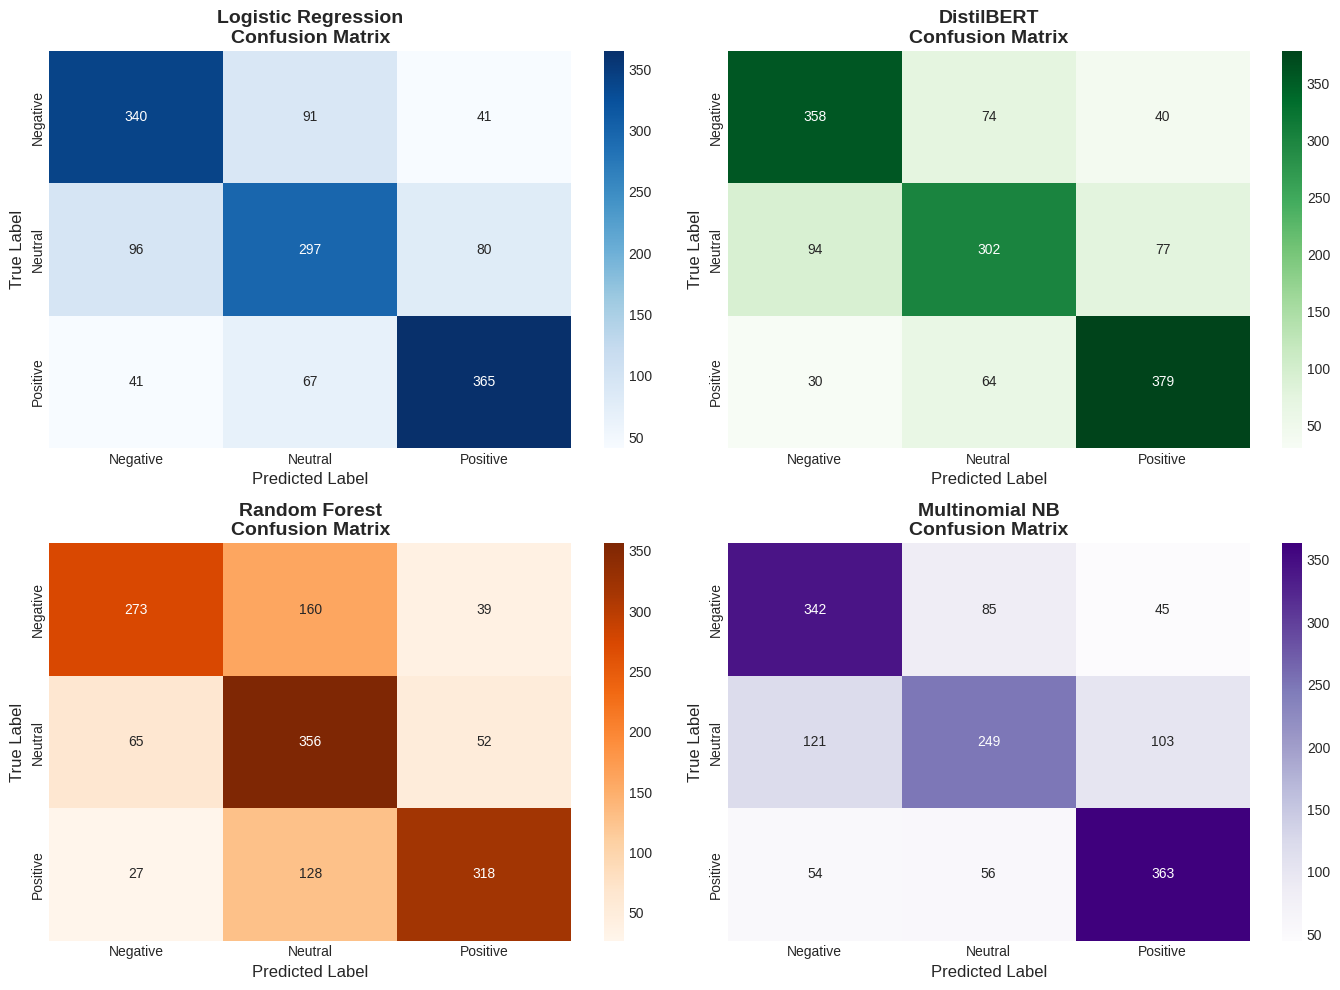


 Performance Metrics Comparison:
------------------------------------------------------------
              Model  Accuracy  F1-Score  Precision   Recall
Logistic Regression  0.706629  0.705939   0.705516 0.706629
         DistilBERT  0.732722  0.731430   0.731063 0.732722
      Random Forest  0.667842  0.670293   0.692710 0.667842
     Multinomial NB  0.672779  0.668807   0.670120 0.672779


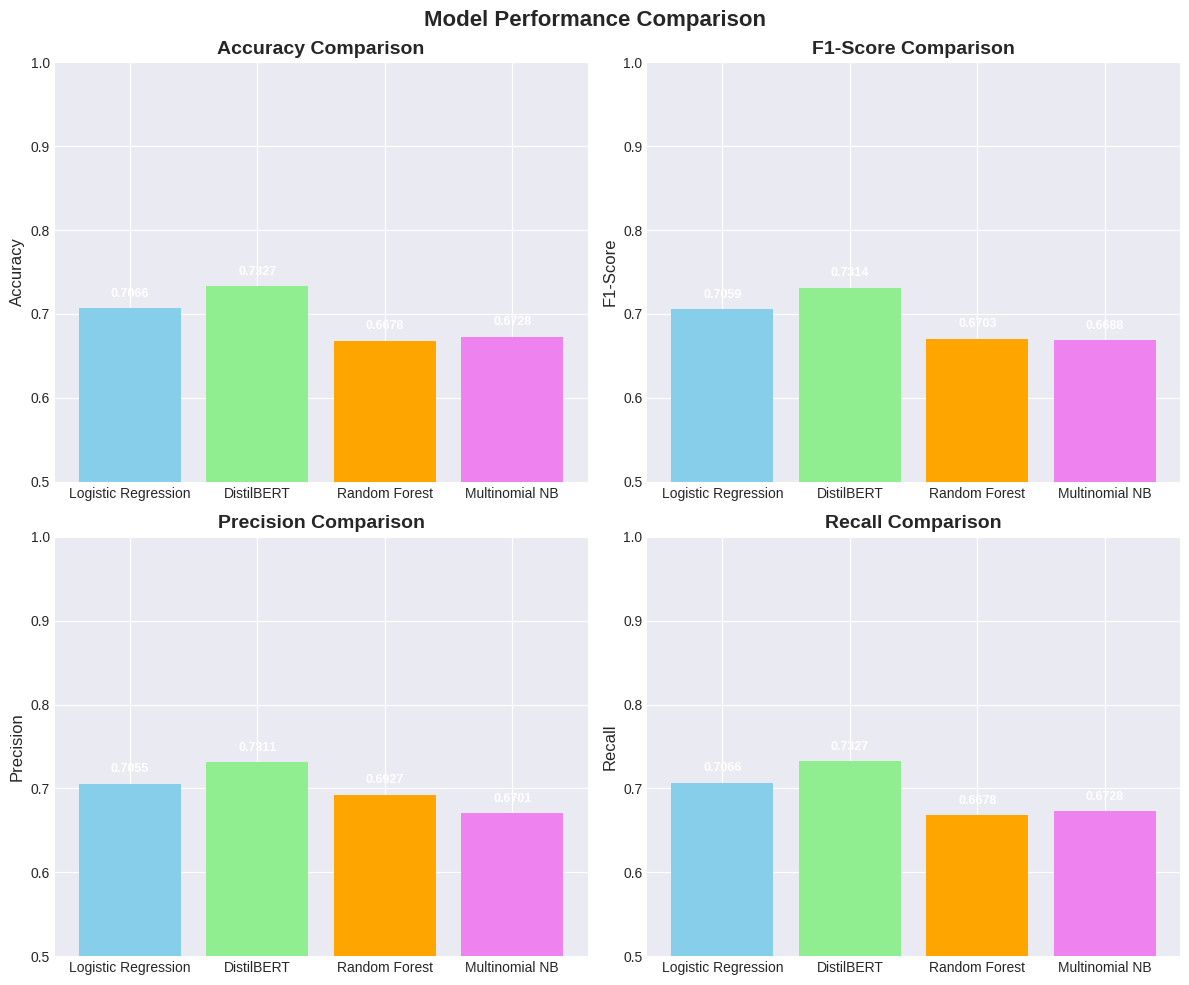

In [22]:
# First, get DistilBERT predictions and probabilities
bert_predictions_output = trainer.predict(test_dataset)
y_pred_bert = np.argmax(bert_predictions_output.predictions, axis=1)
# The output are logits, apply softmax to get probabilities for each class
y_prob_bert = torch.softmax(torch.tensor(bert_predictions_output.predictions), dim=1).numpy()

# Get Multinomial Naive Bayes probabilities
y_prob_mnb = mnb_model.predict_proba(X_test_count)

# Calculate accuracy for all models
lr_accuracy = accuracy_score(test_df['sentiment_label'], y_pred_lr)
rf_accuracy = accuracy_score(test_df['sentiment_label'], y_pred_rf)
nb_accuracy = accuracy_score(test_df['sentiment_label'], y_pred_mnb)

# VISUALIZATION 3: Confusion Matrices Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

class_labels = ['Negative', 'Neutral', 'Positive']

# Logistic Regression Confusion Matrix
cm_lr = confusion_matrix(test_df['sentiment_label'], y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels,
            ax=axes[0, 0])
axes[0, 0].set_title('Logistic Regression\nConfusion Matrix', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Predicted Label', fontsize=12)
axes[0, 0].set_ylabel('True Label', fontsize=12)

# DistilBERT Confusion Matrix
cm_bert = confusion_matrix(test_df['sentiment_label'], y_pred_bert)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_labels,
            yticklabels=class_labels,
            ax=axes[0, 1])
axes[0, 1].set_title('DistilBERT\nConfusion Matrix', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Predicted Label', fontsize=12)
axes[0, 1].set_ylabel('True Label', fontsize=12)

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(test_df['sentiment_label'], y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_labels,
            yticklabels=class_labels,
            ax=axes[1, 0])
axes[1, 0].set_title('Random Forest\nConfusion Matrix', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Predicted Label', fontsize=12)
axes[1, 0].set_ylabel('True Label', fontsize=12)

# Multinomial Naive Bayes Confusion Matrix
cm_nb = confusion_matrix(test_df['sentiment_label'], y_pred_mnb)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_labels,
            yticklabels=class_labels,
            ax=axes[1, 1])
axes[1, 1].set_title('Multinomial NB\nConfusion Matrix', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Predicted Label', fontsize=12)
axes[1, 1].set_ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.show()

# VISUALIZATION 4: ROC Curves Comparison
# (Skipping for now due to complexity of multi-class ROC curves)
# For multi-class, typically one-vs-rest ROC curves are plotted, which requires more specific implementation.

# plt.figure(figsize=(10, 6))

# # ROC Curve for Logistic Regression
# fpr_lr, tpr_lr, _ = roc_curve(test_df['sentiment_label'], y_prob_lr[:, 2]) # Assuming class 2 as positive for example
# roc_auc_lr = auc(fpr_lr, tpr_lr)
# plt.plot(fpr_lr, tpr_lr, color='blue', lw=2,
#          label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})')

# # ROC Curve for DistilBERT
# fpr_bert, tpr_bert, _ = roc_curve(test_df['sentiment_label'], y_prob_bert[:, 2]) # Assuming class 2 as positive for example
# roc_auc_bert = auc(fpr_bert, tpr_bert)
# plt.plot(fpr_bert, tpr_bert, color='green', lw=2,
#          label=f'DistilBERT (AUC = {roc_auc_bert:.3f})')

# # ROC Curve for Random Forest
# fpr_rf, tpr_rf, _ = roc_curve(test_df['sentiment_label'], y_prob_rf[:, 2]) # Assuming class 2 as positive for example
# roc_auc_rf = auc(fpr_rf, tpr_rf)
# plt.plot(fpr_rf, tpr_rf, color='orange', lw=2,
#          label=f'Random Forest (AUC = {roc_auc_rf:.3f})')

# # ROC Curve for Multinomial Naive Bayes
# fpr_nb, tpr_nb, _ = roc_curve(test_df['sentiment_label'], y_prob_mnb[:, 2]) # Assuming class 2 as positive for example
# roc_auc_nb = auc(fpr_nb, tpr_nb)
# plt.plot(fpr_nb, tpr_nb, color='purple', lw=2,
#          label=f'Multinomial NB (AUC = {roc_auc_nb:.3f})')

# # Diagonal line (random classifier)
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--', alpha=0.5)

# plt.xlabel('False Positive Rate', fontsize=12)
# plt.ylabel('True Positive Rate', fontsize=12)
# plt.title('ROC Curves Comparison', fontsize=16, fontweight='bold')
# plt.legend(loc='lower right', fontsize=12)
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

# VISUALIZATION 5: Model Performance Comparison
# Classification report for DistilBERT to get F1, precision, recall
bert_report = classification_report(test_df['sentiment_label'], y_pred_bert, target_names=class_labels, output_dict=True)
bert_f1 = bert_report['weighted avg']['f1-score']
bert_precision = bert_report['weighted avg']['precision']
bert_recall = bert_report['weighted avg']['recall']

# For LR
lr_f1 = f1_score(test_df['sentiment_label'], y_pred_lr, average='weighted')
lr_precision = precision_score(test_df['sentiment_label'], y_pred_lr, average='weighted')
lr_recall = recall_score(test_df['sentiment_label'], y_pred_lr, average='weighted')

# For RF
rf_f1 = f1_score(test_df['sentiment_label'], y_pred_rf, average='weighted')
rf_precision = precision_score(test_df['sentiment_label'], y_pred_rf, average='weighted')
rf_recall = recall_score(test_df['sentiment_label'], y_pred_rf, average='weighted')

# For MNB
nb_f1 = f1_score(test_df['sentiment_label'], y_pred_mnb, average='weighted')
nb_precision = precision_score(test_df['sentiment_label'], y_pred_mnb, average='weighted')
nb_recall = recall_score(test_df['sentiment_label'], y_pred_mnb, average='weighted')


comparison_data = {
    'Model': ['Logistic Regression', 'DistilBERT', 'Random Forest', 'Multinomial NB'],
    'Accuracy': [lr_accuracy, bert_eval_results['eval_accuracy'], rf_accuracy, nb_accuracy],
    'F1-Score': [lr_f1, bert_f1, rf_f1, nb_f1],
    'Precision': [lr_precision, bert_precision, rf_precision, nb_precision],
    'Recall': [lr_recall, bert_recall, rf_recall, nb_recall]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n Performance Metrics Comparison:")
print("-" * 60)
print(comparison_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
colors = ['skyblue', 'lightgreen', 'orange', 'violet']

for idx, metric in enumerate(metrics):
    bars = axes[idx].bar(comparison_df['Model'], comparison_df[metric], color=colors)
    axes[idx].set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    axes[idx].set_ylabel(metric, fontsize=12)
    axes[idx].set_ylim([0.5, 1.0])  # Adjusted for 4 models

    for bar, val in zip(bars, comparison_df[metric]):
        axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                      f'{val:.4f}', ha='center', va='bottom',
                fontsize=9, fontweight='bold', color=color)

plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


TESTING WITH CUSTOM EXAMPLES - ALL MODELS

----------------------------------------------------------------------
INDIVIDUAL PREDICTIONS
----------------------------------------------------------------------

Example 1:
Text: "This product is absolutely amazing! I love it so much."
--------------------------------------------------
Logistic Regression:  Positive   (97.06% confidence)
Random Forest:        Positive   (60.82% confidence)
Multinomial NB:       Positive   (99.91% confidence)
DistilBERT:           Positive   (99.86% confidence)

Example 2:
Text: "Worst purchase ever, complete waste of money."
--------------------------------------------------
Logistic Regression:  Negative   (90.96% confidence)
Random Forest:        Negative   (52.25% confidence)
Multinomial NB:       Negative   (99.99% confidence)
DistilBERT:           Negative   (99.91% confidence)

Example 3:
Text: "It's okay, not great but not terrible either."
--------------------------------------------------
Logisti

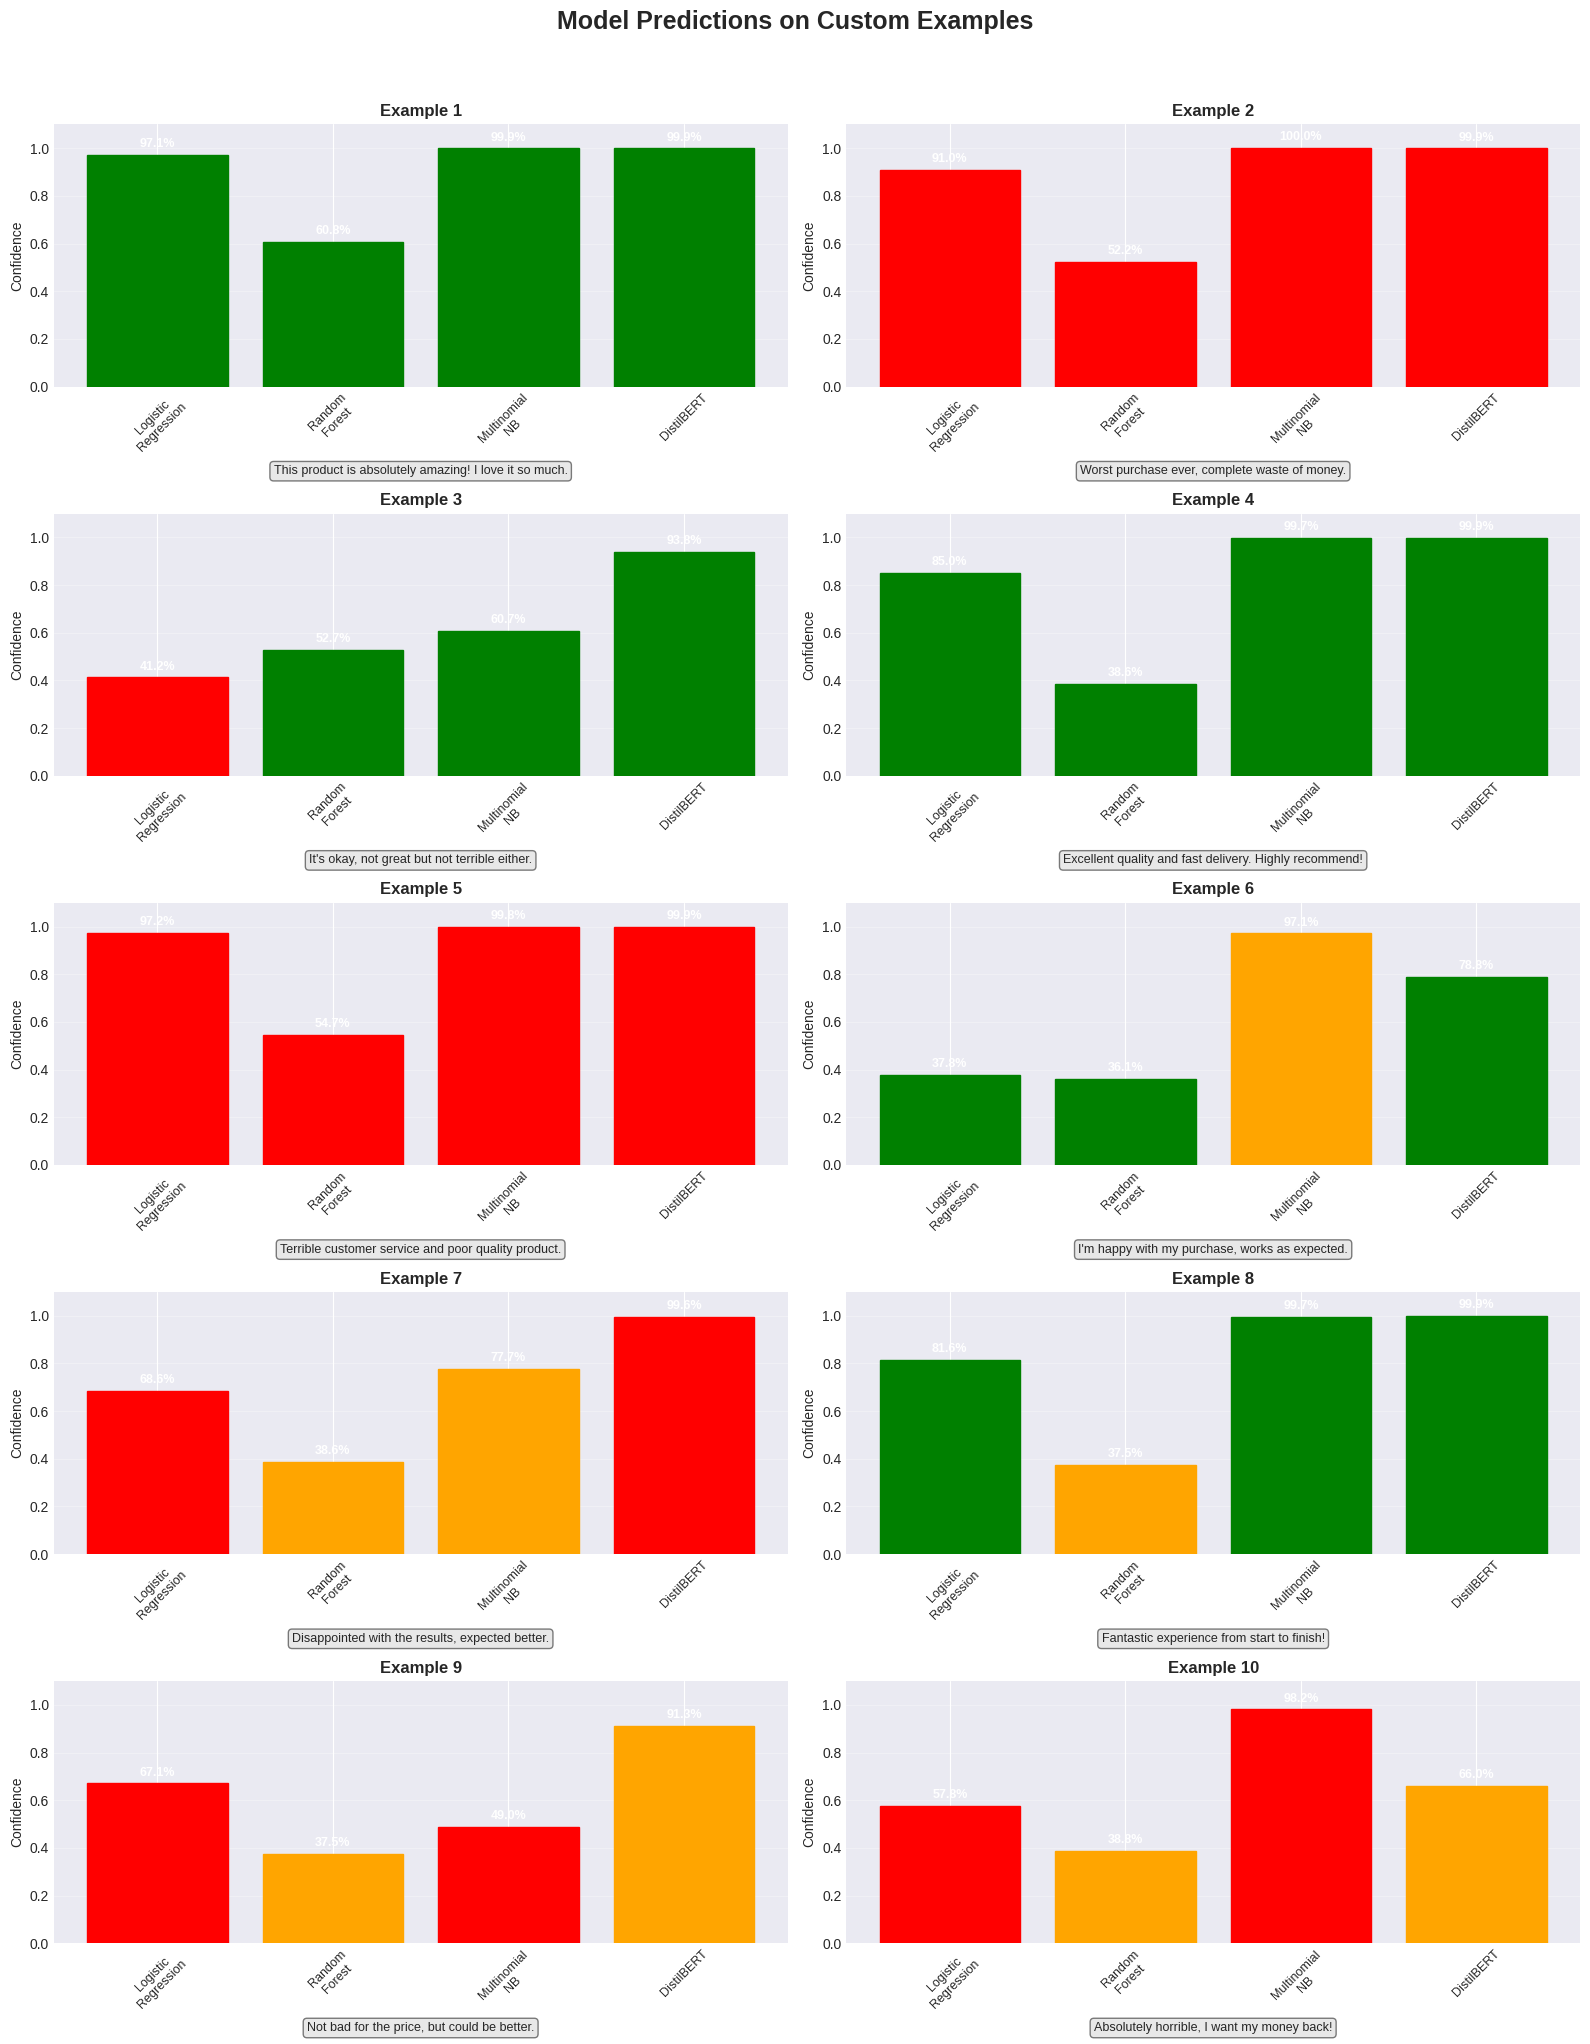

In [19]:
# ==============================================
# TESTING WITH CUSTOM EXAMPLES - ALL MODELS
# ==============================================

print("\n" + "="*70)
print("TESTING WITH CUSTOM EXAMPLES - ALL MODELS")
print("="*70)

# Define custom test examples
custom_examples = [
    "This product is absolutely amazing! I love it so much.",
    "Worst purchase ever, complete waste of money.",
    "It's okay, not great but not terrible either.",
    "Excellent quality and fast delivery. Highly recommend!",
    "Terrible customer service and poor quality product.",
    "I'm happy with my purchase, works as expected.",
    "Disappointed with the results, expected better.",
    "Fantastic experience from start to finish!",
    "Not bad for the price, but could be better.",
    "Absolutely horrible, I want my money back!"
]

# Prepare prediction functions for each model
def predict_with_traditional_model(text, model, vectorizer):
    """Predict sentiment using traditional ML models"""
    text_vectorized = vectorizer.transform([text])
    prediction = model.predict(text_vectorized)[0]
    probability = model.predict_proba(text_vectorized)[0]

    # Map numeric prediction to sentiment string
    if prediction == 0:
        sentiment = "Negative"
    elif prediction == 1:
        sentiment = "Neutral"
    else: # prediction == 2
        sentiment = "Positive"

    confidence = probability[prediction]

    return sentiment, confidence, prediction

# For DistilBERT - adjust based on your implementation
def predict_with_distilbert(text):
    """Predict sentiment using DistilBERT"""
    try:
        # Tokenize input
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)

        # Move input tensors to the same device as the model
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Get prediction
        with torch.no_grad():
            outputs = model(**inputs) # Changed bert_model to model

        # Get probabilities
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        prediction = torch.argmax(probabilities, dim=-1).item()

        # Map numeric prediction to sentiment string
        if prediction == 0:
            sentiment = "Negative"
        elif prediction == 1:
            sentiment = "Neutral"
        else: # prediction == 2
            sentiment = "Positive"

        confidence = probabilities[0][prediction].item()

        return sentiment, confidence, prediction
    except Exception as e:
        print(f"Error in DistilBERT prediction: {e}")
        return "Error", 0.5, -1

# Test each example on all models
results = []

print("\n" + "-"*70)
print("INDIVIDUAL PREDICTIONS")
print("-"*70)

for i, text in enumerate(custom_examples, 1):
    print(f"\nExample {i}:")
    print(f"Text: \"{text}\"")
    print("-" * 50)

    # Logistic Regression
    lr_sentiment, lr_conf, lr_pred = predict_with_traditional_model(text, lr_model, tfidf_vectorizer)
    print(f"Logistic Regression:  {lr_sentiment:10} ({lr_conf:.2%} confidence)")

    # Random Forest
    rf_sentiment, rf_conf, rf_pred = predict_with_traditional_model(text, rf_model, tfidf_vectorizer_rf)
    print(f"Random Forest:        {rf_sentiment:10} ({rf_conf:.2%} confidence)")

    # Multinomial Naive Bayes
    nb_sentiment, nb_conf, nb_pred = predict_with_traditional_model(text, mnb_model, count_vectorizer)
    print(f"Multinomial NB:       {nb_sentiment:10} ({nb_conf:.2%} confidence)")

    # DistilBERT
    bert_sentiment, bert_conf, bert_pred = predict_with_distilbert(text)
    print(f"DistilBERT:           {bert_sentiment:10} ({bert_conf:.2%} confidence)")

    # Store results
    results.append({
        'text': text,
        'logistic_regression': (lr_sentiment, lr_conf, lr_pred),
        'random_forest': (rf_sentiment, rf_conf, rf_pred),
        'multinomial_nb': (nb_sentiment, nb_conf, nb_pred),
        'distilbert': (bert_sentiment, bert_conf, bert_pred)
    })

# Visualization 1: Model Predictions Comparison
print("\n" + "="*70)
print("VISUALIZATION 1: PREDICTIONS COMPARISON")
print("="*70)

fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.flatten()

model_names = ['Logistic\nRegression', 'Random\nForest', 'Multinomial\nNB', 'DistilBERT']
model_keys = ['logistic_regression', 'random_forest', 'multinomial_nb', 'distilbert']
colors = ['skyblue', 'lightgreen', 'orange', 'purple']

for idx, example in enumerate(results[:10]):  # Show all 10 examples
    ax = axes[idx]

    sentiments = []
    confidences = []

    for model_key in model_keys:
        sentiment, confidence, _ = example[model_key]
        sentiments.append(sentiment)
        confidences.append(confidence)

    # Create bars
    bars = ax.bar(model_names, confidences, color=colors)

    # Color bars based on sentiment
    for bar, sentiment in zip(bars, sentiments):
        if sentiment == 'Positive':
            bar.set_color('green')
        elif sentiment == 'Negative':
            bar.set_color('red')
        elif sentiment == 'Neutral': # Added Neutral case
            bar.set_color('orange')
        else:  # Error case
            bar.set_color('gray')

    # Customize plot
    ax.set_ylim([0, 1.1])
    ax.set_ylabel('Confidence', fontsize=10)
    ax.set_title(f'Example {idx+1}', fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    ax.grid(True, alpha=0.3, axis='y')

    # Add value labels
    for bar, conf, sentiment in zip(bars, confidences, sentiments):
        height = bar.get_height()
        color = 'white' if sentiment != 'Error' else 'black'
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{conf:.1%}', ha='center', va='bottom',
                fontsize=9, fontweight='bold', color=color)

    # Truncate text for display
    display_text = example['text']
    if len(display_text) > 60:
        display_text = display_text[:57] + "..."

    # Add text below plot
    ax.text(0.5, -0.3, display_text, ha='center', va='top',
            transform=ax.transAxes, fontsize=9, wrap=True,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.5))

plt.suptitle('Model Predictions on Custom Examples', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()